### 1. Read Data

In [1]:
# Imports
import pandas as pd

# Read in 2 Data Files and Combine, Mark as M/F
female_data = pd.read_csv('file_list_female_parsed_with_data.csv')
male_data = pd.read_csv('file_list_male_parsed_with_data.csv')
female_data['gender'] = 0  # Female data is 0
male_data['gender'] = 1    # Male data is 1
combined_data = pd.concat([female_data, male_data], ignore_index=True)
# combined_data.to_csv('combined_dataset.csv', index=False)
print(combined_data.shape)
print(combined_data.head())

(1001966, 17)
                experiment_name video_base_name  track_id  count_uncalibrated  \
0  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                   0   
1  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                   1   
2  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                  10   
3  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                 100   
4  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                1000   

   new_count_uncalibrated          xc          yc     u_dot      v_dot  \
0                  382058  117.405639  104.372970  6.973857  22.796302   
1                  382059  123.302195  123.913192  6.585702  21.623125   
2                  382068  111.683189  400.633206 -0.382109  28.731078   
3                  382158  821.635502  527.801237  5.468046  -3.778739   
4                  383058  883.833486  309.388663  2.265553   0.529649   

         s_dot  class_id   p_value  track_length      

In [2]:
# Rename Data
data = combined_data

# Create Unique Identifier
data['id'] = data['experiment_name'] + '__' + data['video_base_name'] + '__' + data['track_id'].astype(str)

# Save Class ID for Later Comparison
class_id_array = data[['gender', 'id']].copy()

# Drop Potential Labels
data.drop('gender', inplace=True, axis=1) 

# Drop Cols that We Might Need
data.drop('w', inplace=True, axis=1) 
data.drop('h', inplace=True, axis=1) 
data.drop('p_value', inplace=True, axis=1) 
data.drop('track_id', inplace=True, axis=1) 
data.drop('class_id', inplace=True, axis=1)
data.drop('track_length', inplace=True, axis=1) 
data.drop('experiment_name', inplace=True, axis=1) 
data.drop('video_base_name', inplace=True, axis=1) 
data.drop('count_uncalibrated', inplace=True, axis=1) 
data.drop('new_count_uncalibrated', inplace=True, axis=1) 

# Check Modified Data
print("Modified CSV Data: \n") 
print(data)

# Rename DF
df = data

Modified CSV Data: 

                 xc          yc     u_dot      v_dot        s_dot   frame  \
0        117.405639  104.372970  6.973857  22.796302  4094.324244  382058   
1        123.302195  123.913192  6.585702  21.623125  4154.148577  382059   
2        111.683189  400.633206 -0.382109  28.731078  1993.790100  382068   
3        821.635502  527.801237  5.468046  -3.778739    82.335724  382158   
4        883.833486  309.388663  2.265553   0.529649    -4.429363  383058   
...             ...         ...       ...        ...          ...     ...   
1001961  156.276651  671.360475  4.437002   6.482767    23.792231  537123   
1001962  162.206921  672.395285  4.571728   5.991240    25.240829  537124   
1001963  170.841343  672.257588  4.938269   5.438280    26.805397  537125   
1001964  178.862178  673.323482  5.216379   5.043803    29.915899  537126   
1001965  187.945173  674.862680  5.565223   4.727619    30.420474  537127   

                                                    id

In [3]:
# Add in Labels
# print(class_id_array.tail())
averaged_class_id = class_id_array.groupby('id')['gender'].mean().round().astype(int).reset_index()
averaged_class_id = averaged_class_id.rename(columns={'id': 'id2'})
print(averaged_class_id)

                                               id2  gender
0     MC_singlenuc23_1_Tk33_021220__0001_vid__1330       0
1     MC_singlenuc23_1_Tk33_021220__0001_vid__1573       0
2     MC_singlenuc23_1_Tk33_021220__0001_vid__1640       0
3     MC_singlenuc23_1_Tk33_021220__0001_vid__1748       0
4     MC_singlenuc23_1_Tk33_021220__0001_vid__2085       0
..                                             ...     ...
666  MC_singlenuc96_b1_Tk41_081120__0001_vid__8792       1
667  MC_singlenuc96_b1_Tk41_081120__0001_vid__8893       1
668  MC_singlenuc96_b1_Tk41_081120__0001_vid__9161       0
669  MC_singlenuc96_b1_Tk41_081120__0001_vid__9345       0
670  MC_singlenuc96_b1_Tk41_081120__0001_vid__9350       1

[671 rows x 2 columns]


### 2. Combine Frames by Track & Create Features

In [4]:
# Imports
import numpy as np

In [5]:
# Engineered Features
def calculate_speed(df):
    df['speed'] = np.sqrt(df['u_dot']**2 + df['v_dot']**2)
    return df

def calculate_outreach_ratio(df):
    start_x, start_y = df.iloc[0][['xc', 'yc']]
    end_x, end_y = df.iloc[-1][['xc', 'yc']]
    displacement = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    path_length = df['speed'].sum()
    outreach_ratio = displacement / path_length if path_length != 0 else 0
    return outreach_ratio

def calculate_acceleration(u_dot, v_dot, time_intervals):
    u_dot = np.array(u_dot)
    v_dot = np.array(v_dot)
    time_intervals = np.array(time_intervals)
    ax = np.diff(u_dot) / time_intervals[:-1]
    ay = np.diff(v_dot) / time_intervals[:-1]
    acceleration = np.sqrt(ax**2 + ay**2)
    return ax, ay, acceleration

def calculate_distance_traveled(xc, yc):
    xc = np.array(xc)
    yc = np.array(yc)
    dx = np.diff(xc)
    dy = np.diff(yc)
    distances = np.sqrt(dx**2 + dy**2)
    distance_traveled = np.sum(distances)
    return distance_traveled

In [6]:
# Create Features from TrackID
features = []
grouped = data.groupby('id')

for track_id, group in grouped:
    group = group.sort_values(by='frame')
    speed = calculate_speed(group)['speed'].mean()
    outreach_ratio = calculate_outreach_ratio(group)
    time_intervals = group['frame'].diff().fillna(1).values  # Assume frame difference as time interval
    ax, ay, acceleration = calculate_acceleration(group['u_dot'], group['v_dot'], time_intervals)
    mean_acceleration = np.mean(acceleration)
    distance_traveled = calculate_distance_traveled(group['xc'], group['yc'])
    features.append({
        'id': track_id,
        'speed': speed,
        'outreach_ratio': outreach_ratio,
        'mean_acceleration': mean_acceleration,
        'distance_traveled': distance_traveled
    })

features_df = pd.DataFrame(features)
print(features_df.head())

                                             id     speed  outreach_ratio  \
0  MC_singlenuc23_1_Tk33_021220__0001_vid__1330  2.669734        0.086335   
1  MC_singlenuc23_1_Tk33_021220__0001_vid__1573  2.306083        0.027860   
2  MC_singlenuc23_1_Tk33_021220__0001_vid__1640  2.884547        0.032662   
3  MC_singlenuc23_1_Tk33_021220__0001_vid__1748  2.867001        0.088994   
4  MC_singlenuc23_1_Tk33_021220__0001_vid__2085  2.646049        0.021937   

   mean_acceleration  distance_traveled  
0           0.281946       15439.795210  
1           0.272332       19066.584148  
2           0.269384       12638.557458  
3           0.295195        7729.860738  
4           0.268153       10632.973318  


In [7]:
# Create DF to Compare to Labels
combined_df = pd.concat([features_df, averaged_class_id], axis=1)
comparison_df = combined_df.drop(columns=['id2'])
comparison_df = comparison_df.rename(columns={'gender': 'is_male'})
print(comparison_df)

# Tally Males and Females
tally = comparison_df['is_male'].value_counts()
print(tally)

                                                id     speed  outreach_ratio  \
0     MC_singlenuc23_1_Tk33_021220__0001_vid__1330  2.669734        0.086335   
1     MC_singlenuc23_1_Tk33_021220__0001_vid__1573  2.306083        0.027860   
2     MC_singlenuc23_1_Tk33_021220__0001_vid__1640  2.884547        0.032662   
3     MC_singlenuc23_1_Tk33_021220__0001_vid__1748  2.867001        0.088994   
4     MC_singlenuc23_1_Tk33_021220__0001_vid__2085  2.646049        0.021937   
..                                             ...       ...             ...   
666  MC_singlenuc96_b1_Tk41_081120__0001_vid__8792  7.188265        0.222151   
667  MC_singlenuc96_b1_Tk41_081120__0001_vid__8893  4.243637        0.212326   
668  MC_singlenuc96_b1_Tk41_081120__0001_vid__9161  1.225791        0.143379   
669  MC_singlenuc96_b1_Tk41_081120__0001_vid__9345  2.434414        0.081309   
670  MC_singlenuc96_b1_Tk41_081120__0001_vid__9350  5.231545        0.056981   

     mean_acceleration  distance_travel

### 3. Split Data

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(comparison_df, test_size=0.2, random_state=42)
print(train_df.shape)
print(test_df.shape)

(536, 6)
(135, 6)


### 4. Cluster Data for Additional Feature Based on Training

In [9]:
# This cell is to prevent the KMeans memory leak on Windows with MKL.
import os
os.environ['OMP_NUM_THREADS'] = '3'

In [10]:
# Imports
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

In [11]:
# Data
data = train_df.drop(columns=['is_male', 'id'])
print(data)

        speed  outreach_ratio  mean_acceleration  distance_traveled
479  4.589509        0.227922           0.276019        5219.392562
604  4.243688        0.392911           0.247718        1676.180926
61   4.692883        0.087671           0.378353        3471.466742
145  2.289939        0.194400           0.184402        4667.404481
353  1.758297        0.044816           0.173079        7651.335852
..        ...             ...                ...                ...
71   5.003619        0.035721           0.379021        3068.113910
106  4.982890        0.099115           0.469955        4021.003965
270  3.827775        0.136342           0.294142        3133.948689
435  0.994422        0.051759           0.165630        3221.862718
102  4.472011        0.643804           0.312395        2361.994112

[536 rows x 4 columns]


In [12]:
# Update Var Name
X_train = data

In [13]:
# Use Silhouette Score for Finding Num Components
silhouette_scores = []
for n_components in range(2, 11):
    gm = GaussianMixture(n_components=n_components, init_params='random', random_state=8).fit(X_train)
    labels = gm.predict(X_train)
    silhouette_scores.append(silhouette_score(X_train, labels))
best_n_components = np.argmax(silhouette_scores) + 2  # Add 2 because we started from 2 components
print("Best number of components:", best_n_components)

Best number of components: 2


In [14]:
# Use BIC Score to Choose Num Components
### Using BIC because it works better for smaller datasets that are less complex compared to AIC.
### If I don't use init_params='random', I get 2 clusters, but this init uses k means, which has Windows memory leak.
n_components = np.arange(1, 11) 
models = [GaussianMixture(n, init_params='random', covariance_type='full', random_state=8).fit(X_train) for n in n_components]
bic_scores = [model.bic(X_train) for model in models]
best_n = n_components[np.argmin(bic_scores)]
print("Best number of clusters:", best_n)

Best number of clusters: 3


In [15]:
# Use AIC Score to Choose Num Components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, init_params='random', covariance_type='full', random_state=8).fit(X_train) for n in n_components]
aic_scores = [model.aic(X_train) for model in models]
best_n = n_components[np.argmin(aic_scores)]
print("Best number of clusters:", best_n)

Best number of clusters: 10


In [16]:
# Cluster
gm = GaussianMixture(n_components=9, random_state=0)
gm = gm.fit(data.values)
labels = gm.predict(data.values)
# centroids = gm.cluster_centers_ 
data['cluster'] = gm.fit_predict(data)

# Check Clusters
print(data.tail())

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster
71   5.003619        0.035721           0.379021        3068.113910        4
106  4.982890        0.099115           0.469955        4021.003965        7
270  3.827775        0.136342           0.294142        3133.948689        0
435  0.994422        0.051759           0.165630        3221.862718        5
102  4.472011        0.643804           0.312395        2361.994112        4


C:\Users\kaiwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\kaiwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


C:\Users\kaiwi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


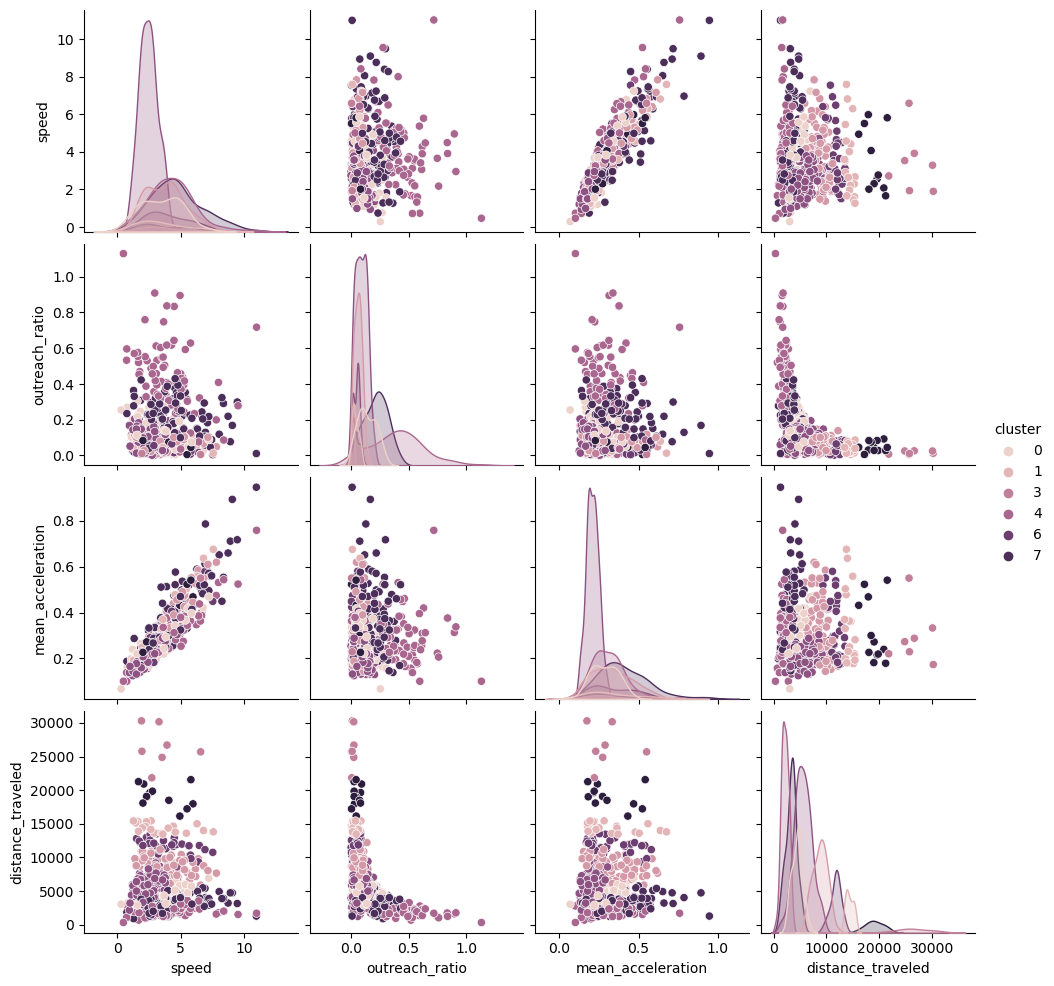

In [17]:
# Pair Plot
sns.pairplot(data, hue='cluster', diag_kind='kde')
plt.show()

In [18]:
# Check Data
print(data)

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster
479  4.589509        0.227922           0.276019        5219.392562        0
604  4.243688        0.392911           0.247718        1676.180926        4
61   4.692883        0.087671           0.378353        3471.466742        7
145  2.289939        0.194400           0.184402        4667.404481        5
353  1.758297        0.044816           0.173079        7651.335852        5
..        ...             ...                ...                ...      ...
71   5.003619        0.035721           0.379021        3068.113910        4
106  4.982890        0.099115           0.469955        4021.003965        7
270  3.827775        0.136342           0.294142        3133.948689        0
435  0.994422        0.051759           0.165630        3221.862718        5
102  4.472011        0.643804           0.312395        2361.994112        4

[536 rows x 5 columns]


In [19]:
# Add Real Label
data = pd.merge(data, train_df[['is_male', 'id']], left_index=True, right_index=True)
print(data)
data.to_csv('5_Features_with_ID_80_Percent.csv', index=False)

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
479  4.589509        0.227922           0.276019        5219.392562        0   
604  4.243688        0.392911           0.247718        1676.180926        4   
61   4.692883        0.087671           0.378353        3471.466742        7   
145  2.289939        0.194400           0.184402        4667.404481        5   
353  1.758297        0.044816           0.173079        7651.335852        5   
..        ...             ...                ...                ...      ...   
71   5.003619        0.035721           0.379021        3068.113910        4   
106  4.982890        0.099115           0.469955        4021.003965        7   
270  3.827775        0.136342           0.294142        3133.948689        0   
435  0.994422        0.051759           0.165630        3221.862718        5   
102  4.472011        0.643804           0.312395        2361.994112        4   

     is_male                           

### 5. Cluster Testing Data for Future Use

In [20]:
# Check Test Data
print(test_df)

                                                id     speed  outreach_ratio  \
361   MC_singlenuc59_4_Tk61_060220__0001_vid__4557  1.585728        0.074931   
158   MC_singlenuc36_2_Tk3_030320__0001_vid__21205  3.658422        0.505757   
480   MC_singlenuc76_3_Tk47_072920__0002_vid__6799  4.705916        0.205379   
641  MC_singlenuc94_b1_Tk31_081120__0001_vid__7673  3.103947        0.052069   
275   MC_singlenuc45_7_Tk47_050720__0002_vid__1867  4.334972        0.462863   
..                                             ...       ...             ...   
420   MC_singlenuc64_1_Tk51_060220__0001_vid__1738  1.926927        0.092053   
551  MC_singlenuc86_b1_Tk47_073020__0001_vid__9998  3.698652        0.300971   
212     MC_singlenuc40_2_Tk3_030920__0001_vid__718  2.642679        0.038676   
18   MC_singlenuc23_1_Tk33_021220__0002_vid__12986  2.998338        0.120524   
235    MC_singlenuc41_2_Tk9_030920__0001_vid__2358  2.471434        0.108882   

     mean_acceleration  distance_travel

In [21]:
# Remove Track ID and Cluster
features_df = test_df
features_df_no_track_id = features_df.drop('id', axis=1)
features_df_no_track_id = features_df_no_track_id.drop('is_male', axis=1)
print(features_df_no_track_id)
predicted_clusters = gm.predict(features_df_no_track_id)

# Add to DF
features_df = features_df.assign(predicted_clusters=predicted_clusters)
test_df_prepared = features_df
print(test_df_prepared)

        speed  outreach_ratio  mean_acceleration  distance_traveled
361  1.585728        0.074931           0.145612        6943.312621
158  3.658422        0.505757           0.278558        1519.459453
480  4.705916        0.205379           0.300472        3140.373418
641  3.103947        0.052069           0.293076        3532.594956
275  4.334972        0.462863           0.316700        2505.056418
..        ...             ...                ...                ...
420  1.926927        0.092053           0.200224        3651.796434
551  3.698652        0.300971           0.239963        5115.032168
212  2.642679        0.038676           0.231453       19488.681351
18   2.998338        0.120524           0.211615       10008.802794
235  2.471434        0.108882           0.184052        7651.145337

[135 rows x 4 columns]
                                                id     speed  outreach_ratio  \
361   MC_singlenuc59_4_Tk61_060220__0001_vid__4557  1.585728        0.074931   


### 6. Find New Cutoffs Based on Training

In [22]:
# Total Number of Rows
# data = X_train
print(data.shape)

(536, 7)


In [23]:
# Should be Mostly Female
outreach_ratio_filtered = data[data['outreach_ratio'] >= 0.4]
print(outreach_ratio_filtered)
total_count = len(outreach_ratio_filtered)
female_count = len(outreach_ratio_filtered[outreach_ratio_filtered['is_male'] == 0])
print(f'Total Count: {total_count}')
print(f'Num Females: {female_count}')
percentage_female = (female_count / total_count) * 100
print(f'Percentage of Females: {percentage_female}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
382   7.992334        0.408574           0.530877        1790.127914        4   
104   3.889388        0.408020           0.327125        2084.076719        4   
114   4.952444        0.895343           0.313430        1621.891618        4   
589   5.010369        0.447068           0.448113        2523.819644        4   
42    4.488214        0.833994           0.374941        1751.614699        4   
412   0.739562        0.596163           0.100888        2787.045446        4   
616   3.075805        0.458080           0.267743        3051.604491        4   
290   3.465992        0.414184           0.237420        2238.890524        4   
33    5.783099        0.628955           0.419941        2406.921146        4   
645   2.657192        0.487331           0.249233        2438.401850        4   
259   2.347539        0.529991           0.218076        2433.438160        4   
377   5.163713        0.4357

In [24]:
# Should be Mostly Male
speed_filtered = data[data['speed'] >= 8.5]
print(speed_filtered)
total_count = len(speed_filtered)
male_count = len(speed_filtered[speed_filtered['is_male'] == 1])
print(f'Total Count: {total_count}')
print(f'Num Males: {male_count}')
percentage_male = (male_count / total_count) * 100
print(f'Percentage of Males: {percentage_male}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
663   8.751024        0.218963           0.659499        3227.344282        7   
48    9.085834        0.167999           0.892974        4740.938434        7   
26    8.927621        0.076615           0.711014        4744.522048        7   
392   9.477585        0.298873           0.717047        3157.177255        7   
391   9.539883        0.277987           0.524019        1529.268095        4   
379  10.986951        0.010228           0.945864        1294.406761        7   
372  11.005271        0.717670           0.758234        1715.776836        4   

     is_male                                             id  
663        1  MC_singlenuc96_b1_Tk41_081120__0001_vid__8641  
48         1    MC_singlenuc23_8_Tk33_031720__0001_vid__808  
26         1   MC_singlenuc23_8_Tk33_031720__0001_vid__2340  
392        1    MC_singlenuc62_3_Tk65_060220__0001_vid__561  
391        1     MC_singlenuc62_3_Tk65_06

In [25]:
# Should be Mostly Male
mean_acceleration_filtered = data[data['mean_acceleration'] >= 0.55]
print(mean_acceleration_filtered)
total_count = len(mean_acceleration_filtered)
male_count = len(mean_acceleration_filtered[mean_acceleration_filtered['is_male'] == 1])
print(f'Total Count: {total_count}')
print(f'Num Males: {male_count}')
percentage_male = (male_count / total_count) * 100
print(f'Percentage of Males: {percentage_male}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
587   8.046634        0.118506           0.651314        4930.087124        7   
274   6.282836        0.151013           0.589106        5102.247184        7   
260   6.959588        0.129127           0.785836        4037.814705        7   
451   6.401354        0.085061           0.584661        9809.312529        2   
663   8.751024        0.218963           0.659499        3227.344282        7   
46    7.122792        0.182925           0.580213        3903.890589        7   
457   7.825643        0.048305           0.619174        7672.045440        2   
48    9.085834        0.167999           0.892974        4740.938434        7   
26    8.927621        0.076615           0.711014        4744.522048        7   
446   6.293319        0.059196           0.558254       15009.317872        1   
576   6.924920        0.058036           0.579482       11163.452342        6   
119   7.225478        0.2176

In [34]:
# Percentage Likelihood of Being Male
cluster_counts = data['cluster'].value_counts()
cluster_percentages = data.groupby('cluster')['is_male'].apply(lambda x: (x == 1).mean() * 100)
result_df = pd.DataFrame({'Count': cluster_counts, 'Percentage Likelihood of Being Male': cluster_percentages})
result_df_sorted = result_df.sort_values(by='Percentage Likelihood of Being Male', ascending=False)
print(result_df_sorted)

# Save Highest Likelihood
highest_likelihood_male_cluster = result_df_sorted.index[0]
print(highest_likelihood_male_cluster)

         Count  Percentage Likelihood of Being Male
cluster                                            
3            7                            85.714286
2           75                            64.000000
6           32                            59.375000
8           12                            58.333333
1           19                            52.631579
7           92                            48.913043
5          152                            24.342105
0           59                            23.728814
4           88                            14.772727
3


In [35]:
# Percentage Likelihood of Being Female
cluster_counts = data['cluster'].value_counts()
cluster_percentages = data.groupby('cluster')['is_male'].apply(lambda x: (x == 0).mean() * 100)
result_df = pd.DataFrame({'Count': cluster_counts, 'Percentage Likelihood of Being Female': cluster_percentages})
result_df_sorted = result_df.sort_values(by='Percentage Likelihood of Being Female', ascending=False)
print(result_df_sorted)

# Save Highest Likelihood
highest_likelihood_female_cluster = result_df_sorted.index[0]
print(highest_likelihood_female_cluster)

         Count  Percentage Likelihood of Being Female
cluster                                              
4           88                              85.227273
0           59                              76.271186
5          152                              75.657895
7           92                              51.086957
1           19                              47.368421
8           12                              41.666667
6           32                              40.625000
2           75                              36.000000
3            7                              14.285714
4


In [28]:
# Looks like Some Predictive Power Here
# Cluster = 7 is 93.62% likely to be a female.
# Cluster = 2 is 80.49% likely to be a female.
# Let's save clustering algorithm to joblib file.
import joblib

num_features_gm = gm.n_features_in_
print(num_features_gm)
joblib.dump(gm, 'gaussian_mixture_model.pkl')
joblib.dump(labels, 'labels.pkl')

4


['labels.pkl']

### 7. Classify Test Based on Cutoffs

In [29]:
# Check Data
print(test_df_prepared)

                                                id     speed  outreach_ratio  \
361   MC_singlenuc59_4_Tk61_060220__0001_vid__4557  1.585728        0.074931   
158   MC_singlenuc36_2_Tk3_030320__0001_vid__21205  3.658422        0.505757   
480   MC_singlenuc76_3_Tk47_072920__0002_vid__6799  4.705916        0.205379   
641  MC_singlenuc94_b1_Tk31_081120__0001_vid__7673  3.103947        0.052069   
275   MC_singlenuc45_7_Tk47_050720__0002_vid__1867  4.334972        0.462863   
..                                             ...       ...             ...   
420   MC_singlenuc64_1_Tk51_060220__0001_vid__1738  1.926927        0.092053   
551  MC_singlenuc86_b1_Tk47_073020__0001_vid__9998  3.698652        0.300971   
212     MC_singlenuc40_2_Tk3_030920__0001_vid__718  2.642679        0.038676   
18   MC_singlenuc23_1_Tk33_021220__0002_vid__12986  2.998338        0.120524   
235    MC_singlenuc41_2_Tk9_030920__0001_vid__2358  2.471434        0.108882   

     mean_acceleration  distance_travel

In [33]:
# Initialize 'predicted_is_male' with random 0s and 1s
np.random.seed(42)  # Set seed for reproducibility
test_df_prepared['predicted_is_male'] = np.random.randint(2, size=len(test_df_prepared))

# Add columns to track which rules were applied
test_df_prepared['rule1_applied'] = 0
test_df_prepared['rule2_applied'] = 0
test_df_prepared['rule3_applied'] = 0

# Apply rules and track them
test_df_prepared['predicted_is_male'] = test_df_prepared.apply(
    lambda row: 1 if row['mean_acceleration'] >= 0.55 else row['predicted_is_male'], axis=1)
test_df_prepared['rule1_applied'] = test_df_prepared.apply(
    lambda row: 1 if row['mean_acceleration'] >= 0.55 else 0, axis=1)

test_df_prepared['predicted_is_male'] = test_df_prepared.apply(
    lambda row: 1 if row['speed'] >= 8.5 else row['predicted_is_male'], axis=1)
test_df_prepared['rule2_applied'] = test_df_prepared.apply(
    lambda row: 1 if row['speed'] >= 8.5 else 0, axis=1)

test_df_prepared['predicted_is_male'] = test_df_prepared.apply(
    lambda row: 0 if row['outreach_ratio'] >= 0.4 else row['predicted_is_male'], axis=1)
test_df_prepared['rule3_applied'] = test_df_prepared.apply(
    lambda row: 1 if row['outreach_ratio'] >= 0.4 else 0, axis=1)

# Check Accuracy
accuracy = (test_df_prepared['is_male'] == test_df_prepared['predicted_is_male']).mean()

# Calculate percentage of rows where each rule was applied
rule1_percentage = test_df_prepared['rule1_applied'].mean() * 100
rule2_percentage = test_df_prepared['rule2_applied'].mean() * 100
rule3_percentage = test_df_prepared['rule3_applied'].mean() * 100

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Percentage of rows where Rule 1 was applied: {rule1_percentage:.2f}%")
print(f"Percentage of rows where Rule 2 was applied: {rule2_percentage:.2f}%")
print(f"Percentage of rows where Rule 3 was applied: {rule3_percentage:.2f}%")

# Display the resulting DataFrame
print(test_df_prepared)

Accuracy: 0.56
Percentage of rows where Rule 1 was applied: 5.19%
Percentage of rows where Rule 2 was applied: 0.00%
Percentage of rows where Rule 3 was applied: 7.41%
                                                id     speed  outreach_ratio  \
361   MC_singlenuc59_4_Tk61_060220__0001_vid__4557  1.585728        0.074931   
158   MC_singlenuc36_2_Tk3_030320__0001_vid__21205  3.658422        0.505757   
480   MC_singlenuc76_3_Tk47_072920__0002_vid__6799  4.705916        0.205379   
641  MC_singlenuc94_b1_Tk31_081120__0001_vid__7673  3.103947        0.052069   
275   MC_singlenuc45_7_Tk47_050720__0002_vid__1867  4.334972        0.462863   
..                                             ...       ...             ...   
420   MC_singlenuc64_1_Tk51_060220__0001_vid__1738  1.926927        0.092053   
551  MC_singlenuc86_b1_Tk47_073020__0001_vid__9998  3.698652        0.300971   
212     MC_singlenuc40_2_Tk3_030920__0001_vid__718  2.642679        0.038676   
18   MC_singlenuc23_1_Tk33_02122

In [39]:
# Initialize 'predicted_is_male' with random 0s and 1s
data_df = test_df_prepared
np.random.seed(42)  # Set seed for reproducibility
data_df['predicted_is_male'] = np.random.randint(2, size=len(data_df))

# Add columns to track which rules were applied
data_df['rule1_applied'] = 0
data_df['rule2_applied'] = 0
data_df['rule3_applied'] = 0
data_df['rule4_applied'] = 0
data_df['rule5_applied'] = 0

# Add new rules based on highest likelihood clusters
data_df['predicted_is_male'] = data_df.apply(
    lambda row: 1 if row['predicted_clusters'] == highest_likelihood_male_cluster else row['predicted_is_male'], axis=1)
data_df['rule4_applied'] = data_df.apply(
    lambda row: 1 if row['predicted_clusters'] == highest_likelihood_male_cluster else 0, axis=1)

data_df['predicted_is_male'] = data_df.apply(
    lambda row: 0 if row['predicted_clusters'] == highest_likelihood_female_cluster else row['predicted_is_male'], axis=1)
data_df['rule5_applied'] = data_df.apply(
    lambda row: 1 if row['predicted_clusters'] == highest_likelihood_female_cluster else 0, axis=1)

# Apply rules and track them
data_df['predicted_is_male'] = data_df.apply(
    lambda row: 1 if row['mean_acceleration'] >= 0.55 else row['predicted_is_male'], axis=1)
data_df['rule1_applied'] = data_df.apply(
    lambda row: 1 if row['mean_acceleration'] >= 0.55 else 0, axis=1)

data_df['predicted_is_male'] = data_df.apply(
    lambda row: 1 if row['speed'] >= 8.5 else row['predicted_is_male'], axis=1)
data_df['rule2_applied'] = data_df.apply(
    lambda row: 1 if row['speed'] >= 8.5 else 0, axis=1)

data_df['predicted_is_male'] = data_df.apply(
    lambda row: 0 if row['outreach_ratio'] >= 0.4 else row['predicted_is_male'], axis=1)
data_df['rule3_applied'] = data_df.apply(
    lambda row: 1 if row['outreach_ratio'] >= 0.4 else 0, axis=1)

# Check Accuracy
accuracy = (data_df['is_male'] == data_df['predicted_is_male']).mean()

# Calculate percentage of rows where each rule was applied
rule1_percentage = data_df['rule1_applied'].mean() * 100
rule2_percentage = data_df['rule2_applied'].mean() * 100
rule3_percentage = data_df['rule3_applied'].mean() * 100
rule4_percentage = data_df['rule4_applied'].mean() * 100
rule5_percentage = data_df['rule5_applied'].mean() * 100

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Percentage of rows where Rule 1 was applied: {rule1_percentage:.2f}%")
print(f"Percentage of rows where Rule 2 was applied: {rule2_percentage:.2f}%")
print(f"Percentage of rows where Rule 3 was applied: {rule3_percentage:.2f}%")
print(f"Percentage of rows where Rule 4 was applied: {rule4_percentage:.2f}%")
print(f"Percentage of rows where Rule 5 was applied: {rule5_percentage:.2f}%")

# Display the resulting DataFrame
print(data_df)

Accuracy: 0.63
Percentage of rows where Rule 1 was applied: 5.19%
Percentage of rows where Rule 2 was applied: 0.00%
Percentage of rows where Rule 3 was applied: 7.41%
Percentage of rows where Rule 4 was applied: 0.00%
Percentage of rows where Rule 5 was applied: 22.22%
                                                id     speed  outreach_ratio  \
361   MC_singlenuc59_4_Tk61_060220__0001_vid__4557  1.585728        0.074931   
158   MC_singlenuc36_2_Tk3_030320__0001_vid__21205  3.658422        0.505757   
480   MC_singlenuc76_3_Tk47_072920__0002_vid__6799  4.705916        0.205379   
641  MC_singlenuc94_b1_Tk31_081120__0001_vid__7673  3.103947        0.052069   
275   MC_singlenuc45_7_Tk47_050720__0002_vid__1867  4.334972        0.462863   
..                                             ...       ...             ...   
420   MC_singlenuc64_1_Tk51_060220__0001_vid__1738  1.926927        0.092053   
551  MC_singlenuc86_b1_Tk47_073020__0001_vid__9998  3.698652        0.300971   
212     M